In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import multivariate_normal
from skimage import io
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D

In [48]:
class kMeans:
    def __init__(self, X, k, N, n_iter = 1000, dimension = 1):
        self.X = X
        self.k = k
        self.N = N
        self.n_iter = n_iter
        self.mu = [[] for i in range(0,k)]
        self.n_changes = 0
        self.mulist = []
        self.dimension = dimension
    
    def initialize_means(self):
        if self.dimension>1:
            rand = np.random.randint(len(self.X), size = self.k)
            self.mu = self.X[rand,:]
        else: 
            self.mu = random.sample(sorted(self.X) ,self.k)
    
    def calculate_means(self):
        self.initialize_means()
        _mu = [[] for i in range(self.k)]
        _mu = np.copy(self.mu)
        for i in range(self.n_iter):
            clusters = self.predict_()
            self.mu = self.update_means(clusters)
            if np.array_equal(self.mu, _mu):
                self.n_changes += 1
                if self.n_changes >= 50:
                    break
            else:
                _mu = np.copy(self.mu)                    
        means = sorted(self.mu)
        return means
    
    def update_means(self, clusters):
        m = np.zeros((self.k, self.dimension))
        for i, mean in enumerate(self.mu):
            m[i] = np.mean(clusters[i], axis=0)
        return m
   
    def predict(self, n_runs=50):
        means_list = []
        for i in range(n_runs):
            means = self.calculate_means()
            means_list.append(means)        
        return np.mean(means_list, axis=0)
     
    def predict_(self):
        clusters = [[] for i in range(self.k)]
        for j, x in enumerate(self.X):
            d = []
            d = [calcute_distance(m, x) for m in self.mu]
            clusters[d.index(min(d))].append(x)
        return clusters

In [114]:
class EM:
    def __init__(self, X, k, N, d, n_iter = 50):
        self.X = X
        self.k = k
        self.N = N
        self.d = d
        self.n_iter = n_iter
    
    def posterior(self):
        distributions = []
        for i in range(self.k):
            distributions.append(multivariate_normal(mean = self.mu[i], cov = self.sigma[i]).pdf(self.X))
        num = np.array(distributions).T * self.phi
        den = num.sum(axis=1)[:, np.newaxis]
        return num/den

    def predict(self, n_runs = 50):
        self.w = []
        for i in range(n_runs):
            self.calculate_means()
            self.mu.sort()
            self.w.append(self.mu)
        return np.mean(self.w, axis=0)
    
    def initialize_means(self):
        if self.d>1:
            rand = np.random.randint(len(self.X), size = self.k)
            self.mu = self.X[rand,:]
        else: 
            self.mu = random.sample(sorted(self.X) ,self.k)
    
    def calculate_means(self):
        self.initialize_means()
        self.phi = np.array([(1/self.k) for i in range(self.k)])
        if self.d>1:
            rand = np.random.randint(len(self.X), size = self.k)
            self.mu = self.X[rand,:]
        else:
            self.mu = random.sample(sorted(self.X), self.k)
        self.sigma = [np.cov(self.X.T) for i in range(self.k)]        
        for i in range(self.n_iter):
            self.weights = self.posterior()
            self.phi = np.mean(self.weights, axis = 0)
            for j in range(self.k):
                weight_j = self.weights[:,[j]]
                self.mu[j] = np.sum(self.X * weight_j, axis=0) / np.sum(weight_j)
                self.sigma[j] = np.cov(self.X.T, aweights = (weight_j / np.sum(weight_j)).flatten(), bias=True)

In [31]:
def readfile(exp_num):
    #print(f"Data Set: Experiment{exp_num}")
    data_frame = pd.read_csv(f"File{exp_num}.csv")
    nom_assignments = data_frame['Mean']
    new_df = data_frame.drop(['Mean'],axis=1)
    gaus_data = new_df.to_numpy()
    N,d = gaus_data.shape
    return gaus_data, N, d, nom_assignments.to_numpy()
    
def likelihood(mu, nom):
    likelihoods = []
    for cluster, i in enumerate(mu):
        share, total = 0, 0
        try:
            temp = np.split(np.array(i), 2)
        except ValueError:
            i.pop()
            temp = np.split(np.array(i),2)
        listed = np.stack(temp, axis=1)
        for j in listed:
            if nom[j[0]] == nom[j[1]]:
                share += 1
            total += 1
        if total == 0:
            likelihoods.append(0)
        else:
            likelihoods.append(share/total)
    return np.mean(likelihoods)

def calculate_stdev(mu, X, k, N, d):
    clusters = get_predictions(mu, X, k, calcute_distance)
    stdev = []
    for i, cluster in enumerate(clusters):
        s = 0
        for j, data_point in enumerate(cluster):
            if d == 1:
                s += math.sqrt((mu[i] - data_point) * (mu[i] - data_point))
            else:
                x = 0
                for k in range(0, d):
                    x += (mu[i][k] - data_point[k]) * (mu[i][k] - data_point[k])
                s += math.sqrt(x)
        stdev.append(math.sqrt(s / N))
    return stdev

def get_predictions(mu, data, k, calcute_distance):
    clusters = [[] for i in range(0,k)]
    for j, data_point in enumerate(data):
        d = [calcute_distance(data_point, m) for m in mu]
        optimal_cluster_id = d.index(min(d))
        clusters[optimal_cluster_id].append(j)
    return clusters

def calcute_distance(a, b):
    try:
        d = len(b)
        d = len(a)
    except TypeError:
        return (a - b) * (a - b)
    s = 0
    for i in range(d):
        s += (a[i] - b[i]) * (a[i] - b[i])
    return s

def kMeans_compressor(f, k):
    img = io.imread(f)
    r = img.shape[0]
    c = img.shape[1]
    _img = np.reshape(img, (r*c, 3))
    clf = kMeans(_img, k, r*c, dimension=3)
    pixel_centroids = clf.calculate_means()
    pixel_assignments = get_predictions(pixel_centroids, _img, k, distance_between_points)
    for i, mean_val in enumerate(pixel_centroids):
        for c_idc, data_index in enumerate(pixel_assignments[i]):
            _img[data_index] = mean_val   
    _img = np.reshape(_img, (r, c, 3))
    io.imshow(_img)

def print_output(m, S, N, space, k, nom, preds, stdev, l):
    hd = ["Exp w/: %s" % m, (f"S: {S}, N: {N}, Space: {space}, k: {k}")]
    tb = []
    tb.append(["Nominal means:", nom])
    nr = [round(p[0], 2) for p in preds]
    nsd = [round(s, 2) for s in stdev]
    tb.append([f"Predictions for {k} clusters", nr])
    tb.append(["Standard Deviations:", nsd])
    tb.append([f"Mean Std Deviation for {k} clusters:", round(np.mean(stdev),3)])
    tb.append(["Likelihood of pairs:", round(l,3)])
    print(tabulate(tb, headers=hd, tablefmt="fancy_grid"))
    print("\n")
    
def print_comparison(m1, m2, S, N, space, k, nom, preds1, preds2, stdev1, stdev2, l1, l2):
    hd = ["Exp w/: %s" % m1, (f"S: {S}, N: {N}, Space: {space}, k: {k}"), "Exp w/: %s" % m2, (f"S: {S}, N: {N}, Space: {space}, k: {k}")]
    tb = []
    tb.append(["Nominal Means for %s:" % m1, nom, "Nominal Means for %s:" % m2, nom])
    nr1 = [round(p[0], 2) for p in preds1]
    nr2 = [round(p[0], 2) for p in preds2]
    nsd1 = [round(s, 2) for s in stdev1]
    nsd2 = [round(s, 2) for s in stdev2]
    tb.append([f"Predictions for {k} clusters", nr1, f"Predictions for {k} clusters", nr2])
    tb.append(["Standard Deviations:", nsd1, "Standard Deviations:", nsd2])
    tb.append([f"Mean Std Deviation for k = {k}:", round(np.mean(stdev1),2), f"Mean Std Deviation for k = {k}:", round(np.mean(stdev2),2)])
    tb.append(["Likelihood:", round(l1,2), "Likelihood:", round(l2,2)])
    print(tabulate(tb, headers=hd, tablefmt="fancy_grid"))
    print("\n")

In [160]:
from functools import partial
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def score_SSE(mu, y, X):
    sse = [0 for i in range(0,len(mu))]
    for i, _mu in enumerate(mu):
        s = 0
        for j in y:
            s += calcute_distance(_mu, X[j])
        sse[i] = s
    return np.mean(sse)

def score_Silhouette(X, labels, *, metric="euclidean", sample_size=None, random_state=None, **kwds):
    if sample_size is not None:
        indices = random_state.permutation(X.shape[0])[:sample_size]
        X, labels = X[indices], labels[indices]
    return np.mean(nsilhouette_samples(X, labels, metric=metric, **kwds))

def nsilhouette_samples(X, labels, *, metric="euclidean", **kwds):
    f = np.bincount(labels)
    kwds["metric"] = metric
    reduce_func = partial(_silhouette_reduce, labels=labels, label_freqs=f)
    results = zip(*metrics.pairwise_distances_chunked(X, reduce_func=reduce_func, **kwds))
    intra_d, inter_d = results
    intra_d, inter_d = np.concatenate(intra_d), np.concatenate(inter_clust_dists)
    d = (f - 1).take(labels, mode="clip")
    with np.errstate(divide="ignore", invalid="ignore"):
        intra_d /= d
    _s = inter_d - intra_d
    with np.errstate(divide="ignore", invalid="ignore"):
        _s /= np.maximum(intra_d, inter_d)
    return np.nan_to_num(_s)

def _silhouette_reduce(D_chunk, start, labels, label_freqs):
    clust_dists = np.zeros((len(D_chunk), len(label_freqs)), dtype=D_chunk.dtype)
    for i in range(len(D_chunk)):
        clust_dists[i] += np.bincount(labels, weights=D_chunk[i], minlength=len(label_freqs))
    intra_index = (np.arange(len(D_chunk)), labels[start : start + len(D_chunk)])
    intra_clust_dists = clust_dists[intra_index]
    clust_dists[intra_index] = np.inf
    clust_dists /= label_freqs
    inter_clust_dists = clust_dists.min(axis=1)
    return intra_clust_dists, inter_clust_dists

def score_Calinski_Harabasz(X, labels):
    labels = le.fit_transform(labels)
    n = len(le.classes_)
    extra_disp, intra_disp = 0.0, 0.0
    mean = np.mean(X, axis=0)
    for k in range(n_labels):
        cluster_k = X[labels == k]
        mean_k = np.mean(cluster_k, axis=0)
        extra_disp += len(cluster_k) * np.sum((mean_k - mean) ** 2)
        intra_disp += np.sum((cluster_k - mean_k) ** 2)
    return (1.0 if intra_disp == 0.0 else extra_disp * (X.shape - n) / (intra_disp * (n - 1.0)))

def score_Davies_Bouldin(X, labels):
    labels = le.fit_transform(labels)
    n = len(le.classes_)
    intra_dists = np.zeros(n)
    centroids = np.zeros((n, len(X[0])), dtype=float)
    for k in range(n):
        cluster_k = safe_indexing(X, labels == k)
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(metrics.pairwise_distances(cluster_k, [centroid]))
    centroid_distances = metrics.pairwise_distances(centroids)
    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0
    centroid_distances[centroid_distances == 0] = np.inf
    combined_intra_dists = intra_dists[:, None] + intra_dists
    scores = np.max(combined_intra_dists / centroid_distances, axis=1)
    return np.mean(scores)

def safe_indexing(array, key, axis = 0):
    indices_dtype = type(key)
    if isinstance(key, tuple):
        key = list(key)
    return array[key] if axis == 0 else array[:, key]

## Experiment 1 part 1

In this part we apply k-Means and EM methods to Gaussian Distribution data where number of samples (N) is 1000, Spacing is varied as 0.5, 1, 1.5 and 2 also k is varied as 2, 3, 6 and 8.

In [10]:
#Experiment_1_part_1
print("Experiment 1 with N = 1000, S = 3, standard deviation is 1, k is varied as 2, 3, 6 and 8 also spacing values are varied as 0.5, 1, 1.5 and 2 \n")
S, spaces, ks = 3, [0.5, 1, 1.5, 2], [2, 3, 6, 8]
for i, space in enumerate(spaces):
    for k in ks:
        X, N, d, nom = readfile(i+1)
        clf = EM(X, k, N, d)
        results1 = clf.predict()
        s_d1 = calculate_stdev(results1, X, k, N, d)
        mu = get_predictions(results1, X, k, calcute_distance)
        l1 = likelihood(mu, nom)        
        #kmeans
        clf = kMeans(X, k, N)
        results2 = clf.predict(n_runs=50)
        s_d2 = calculate_stdev(results2, X, k, N, d)
        mu2 = get_predictions(results2, X, k, calcute_distance)
        l2 = likelihood(mu2, nom)

        modelname, modelname2 = "EM", "k-Means"
        print_comparison(modelname, modelname2, S, N, space, k, np.unique(nom), results1, results2, s_d1, s_d2, l1, l2)

Experiment 1 with N = 1000, S = 3, standard deviation is 1, k is varied as 2, 3, 6 and 8 also spacing values are varied as 0.5, 1, 1.5 and 2 

╒═══════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════╤═══════════════════════════════════╕
│ Exp w/: EM                    │ S: 3, N: 1000, Space: 0.5, k: 2   │ Exp w/: k-Means               │ S: 3, N: 1000, Space: 0.5, k: 2   │
╞═══════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════╪═══════════════════════════════════╡
│ Nominal Means for EM:         │ [0.5 1.  1.5]                     │ Nominal Means for k-Means:    │ [0.5 1.  1.5]                     │
├───────────────────────────────┼───────────────────────────────────┼───────────────────────────────┼───────────────────────────────────┤
│ Predictions for 2 clusters    │ [0.53, 1.38]                      │ Predictions for 2 clusters    │ [0.09, 1.81]                      │
├────────────────────────────

In [11]:
#Experiment_1_Part_2
print("Experiment 1 with N = 1000, k = S = (5, 10), standard deviation is 1 and spacing varied as 0.5, 1, 1.5 and 2 \n")
Ss, spaces, exp_num = [5, 10], [0.5, 1, 1.5, 2], 5
for S in generators:
    for space in spaces:
        X, N, d, nom = readfile(exp_num)
        exp_num+=1
        clf = EM(X, S, N, d)
        results1 = clf.predict()
        s_d1 = calculate_stdev(results1, X, S, N, d)
        mu = get_predictions(results1, X, S, calcute_distance)
        lop = likelihood(mu, nom)
        clf = kMeans(X, S, N)
        results2 = clf.predict()
        s_d2 = calculate_stdev(results2, X, S, N, d)
        mu2 = get_predictions(results2, X, S, calcute_distance)
        l2 = likelihood(mu2, nom)

        modelname, modelname2 = "EM", "k-Means"
        print_comparison(modelname, modelname2, S, N, space, S, np.unique(nom), results1, results2, s_d1, s_d2, l1, l2)

Experiment 1 with N = 1000, k = S = (5, 10), standard deviation is 1 and spacing varied as 0.5, 1, 1.5 and 2 

╒═══════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════╤═══════════════════════════════════╕
│ Exp w/: EM                    │ S: 5, N: 1000, Space: 0.5, k: 5   │ Exp w/: k-Means               │ S: 5, N: 1000, Space: 0.5, k: 5   │
╞═══════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════╪═══════════════════════════════════╡
│ Nominal Means for EM:         │ [0.5 1.  1.5 2.  2.5]             │ Nominal Means for k-Means:    │ [0.5 1.  1.5 2.  2.5]             │
├───────────────────────────────┼───────────────────────────────────┼───────────────────────────────┼───────────────────────────────────┤
│ Predictions for 5 clusters    │ [0.49, 1.06, 1.48, 1.88, 2.58]    │ Predictions for 5 clusters    │ [-0.63, 0.48, 1.39, 2.29, 3.36]   │
├───────────────────────────────┼────────────────────────────

In [12]:
#Experiment 2
print("Experiment 2 with N = 1000, k = S = 5, spacing is 3 and standard deviation is varied as 1, 2 and 3 \n")
S, space, stdev = 5, 3, [1,2,3]
for i, s_dev in enumerate(stdev):
    X, N, d, nom = readfile(i+13)
    clf = EM(X, 5, N, d)
    results1 = clf.predict()
    s_d1 = calculate_stdev(results1, X, k, N, d)
    mu = get_predictions(results1, X, k, calcute_distance)
    lop = likelihood(mu, nom)
    clf = kMeans(X, k, N)
    results2 = clf.predict()
    s_d2 = calculate_stdev(results2, X, k, N, d)
    mu2 = get_predictions(results2, X, k, calcute_distance)
    l2 = likelihood(mu2, nom)

    modelname, modelname2 = "EM", "k-Means"
    print_comparison(modelname, modelname2, S, N, space, S, np.unique(nom), results1, results2, s_d1, s_d2, l1, l2)

Experiment 2 with N = 1000, k = S = 5, spacing is 3 and standard deviation is varied as 1, 2 and 3 

╒═══════════════════════════════╤════════════════════════════════════════════════╤═══════════════════════════════╤═════════════════════════════════════════════════════╕
│ Exp w/: EM                    │ S: 5, N: 1000, Space: 3, k: 5                  │ Exp w/: k-Means               │ S: 5, N: 1000, Space: 3, k: 5                       │
╞═══════════════════════════════╪════════════════════════════════════════════════╪═══════════════════════════════╪═════════════════════════════════════════════════════╡
│ Nominal Means for EM:         │ [ 1  4  7 10 13]                               │ Nominal Means for k-Means:    │ [ 1  4  7 10 13]                                    │
├───────────────────────────────┼────────────────────────────────────────────────┼───────────────────────────────┼─────────────────────────────────────────────────────┤
│ Predictions for 5 clusters    │ [1.48, 5.03, 7.2, 8.

In [13]:
#Experiment 3 EM
print("Experiment 2 with N = 1000, k = S = 5, spacing is 1.25 and standard deviation is sampled from uniform distribution over [0.75, 2] \n")
S, space = 5, 1.25
X, N, d, nom = readfile("16")
clf = EM(X, 5, N, d)
results1 = clf.predict()
s_d1 = calculate_stdev(results1, X, S, N, d)
mu1 = get_predictions(results1, X, S, calcute_distance)
l1 = likelihood(mu1, nom)
#kmeans
clf = kMeans(X, S, N)
results2 = clf.predict()
s_d2 = calculate_stdev(results2, X, S, N, d)
mu2 = get_predictions(results2, X, S, calcute_distance)
l2 = likelihood(mu2, nom)

modelname, modelname2 = "EM", "k-Means"
print_comparison(modelname, modelname2, S, N, space, S, np.unique(nom), results1, results2, s_d1, s_d2, l1, l2)

Experiment 2 with N = 1000, k = S = 5, spacing is 1.25 and standard deviation is sampled from uniform distribution over [0.75, 2] 

╒═══════════════════════════════╤════════════════════════════════════╤═══════════════════════════════╤════════════════════════════════════╕
│ Exp w/: EM                    │ S: 5, N: 1000, Space: 1.25, k: 5   │ Exp w/: k-Means               │ S: 5, N: 1000, Space: 1.25, k: 5   │
╞═══════════════════════════════╪════════════════════════════════════╪═══════════════════════════════╪════════════════════════════════════╡
│ Nominal Means for EM:         │ [1.   2.25 3.5  4.75 6.  ]         │ Nominal Means for k-Means:    │ [1.   2.25 3.5  4.75 6.  ]         │
├───────────────────────────────┼────────────────────────────────────┼───────────────────────────────┼────────────────────────────────────┤
│ Predictions for 5 clusters    │ [1.51, 2.39, 3.35, 4.2, 6.0]       │ Predictions for 5 clusters    │ [-0.68, 1.55, 3.47, 5.16, 6.73]    │
├───────────────────────────

In [14]:
#Experiment 4
print("Experiment 4 with N is varied as 100, 1000 and 5000, k = S = 5, spacing is 1.25 and standard deviation is 0.75 \n")
S, exp_path, Ns = 5, 17, [100, 1000, 5000]
for i, n in enumerate(Ns):    
    X, N, d, nom = readfile(exp_path)
    exp_path += 1
    clf = EM(X, S, N, d)
    results1 = clf.predict()
    s_d1 = calculate_stdev(results1, X, k, N, d)
    mu = get_predictions(results1, X, k, calcute_distance)
    lop = likelihood(mu, nom)
    #kmeans
    clf = kMeans(X, k, N)
    results2 = clf.predict()
    s_d2 = calculate_stdev(results2, X, k, N, d)
    mu2 = get_predictions(results2, X, k, calcute_distance)
    l2 = likelihood(mu2, nom)
    modelname, modelname2 = "EM", "k-Means"
    print_comparison(modelname, modelname2, S, N, space, k, np.unique(nom), results1, results2, s_d1, s_d2, l1, l2)

Experiment 4 with N is varied as 100, 1000 and 5000, k = S = 5, spacing is 1.25 and standard deviation is 0.75 

╒═══════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════╤═══════════════════════════════════╕
│ Exp w/: EM                    │ S: 5, N: 100, Space: 1.25, k: 5   │ Exp w/: k-Means               │ S: 5, N: 100, Space: 1.25, k: 5   │
╞═══════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════╪═══════════════════════════════════╡
│ Nominal Means for EM:         │ [1.   2.25 3.5  4.75 6.  ]        │ Nominal Means for k-Means:    │ [1.   2.25 3.5  4.75 6.  ]        │
├───────────────────────────────┼───────────────────────────────────┼───────────────────────────────┼───────────────────────────────────┤
│ Predictions for 5 clusters    │ [0.74, 2.67, 3.68, 4.62, 5.99]    │ Predictions for 5 clusters    │ [0.45, 2.21, 3.74, 5.04, 6.3]     │
├───────────────────────────────┼──────────────────────────

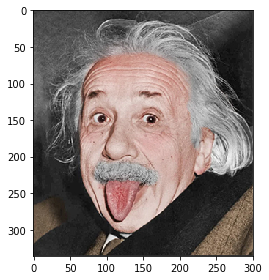

In [59]:
io.imshow("einstein.jpg")

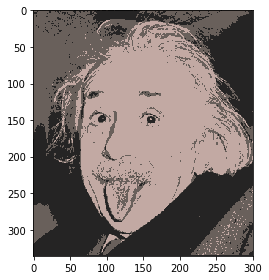

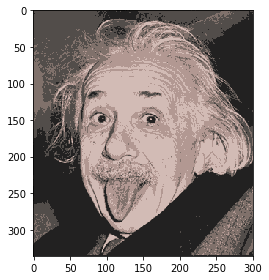

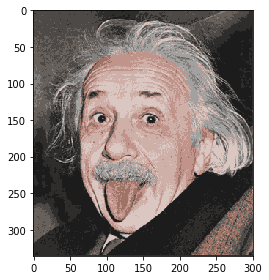

In [58]:
image = io.imread("einstein.jpg")
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(rows*cols, 3)
clusters = [3, 5, 10]
for c in clusters:
    compressed_image = kMeans_compressor("einstein.jpg", c)
    io.imshow(compressed_image)
    io.show()

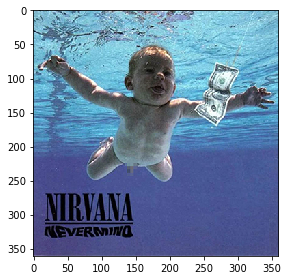

In [60]:
io.imshow("nirvana.jpg")

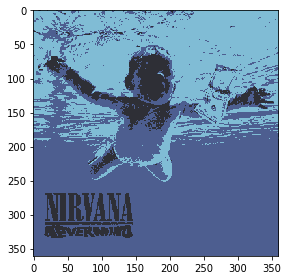

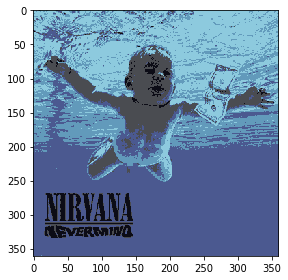

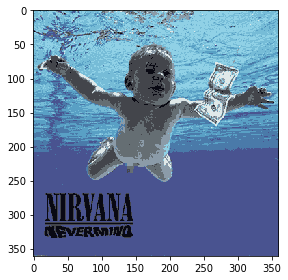

In [61]:
image = io.imread("nirvana.jpg")
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(rows*cols, 3)
clusters = [3, 5, 10]
for c in clusters:
    compressed_image = kMeans_compressor("nirvana.jpg", c)
    io.imshow(compressed_image)
    io.show()

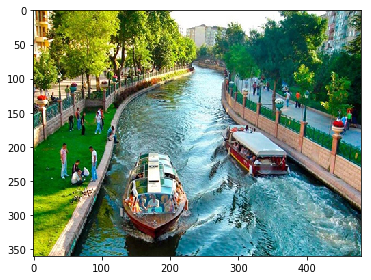

In [62]:
io.imshow("eskisehir.jpg")

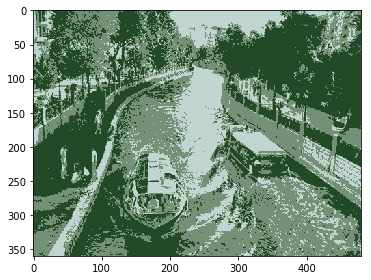

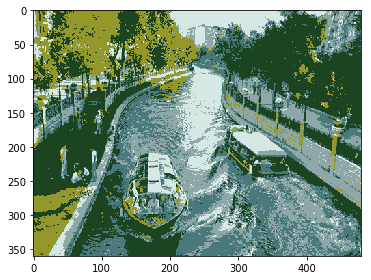

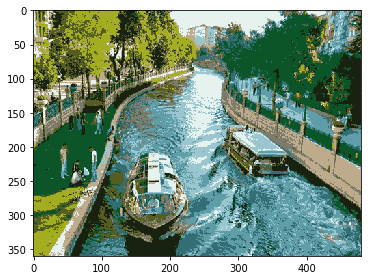

In [63]:
image = io.imread("eskisehir.jpg")
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(rows*cols, 3)
clusters = [3, 5, 10]
for c in clusters:
    compressed_image = kMeans_compressor("eskisehir.jpg", c)
    io.imshow(compressed_image)
    io.show()

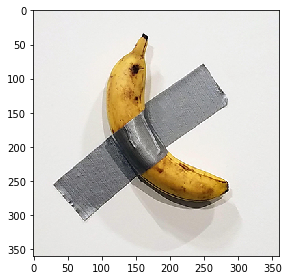

In [64]:
io.imshow("banana.jpg")

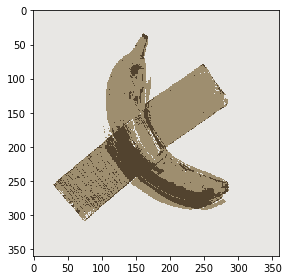

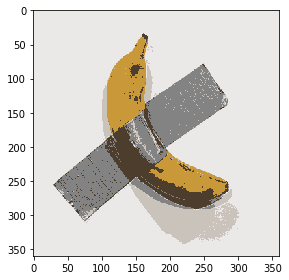

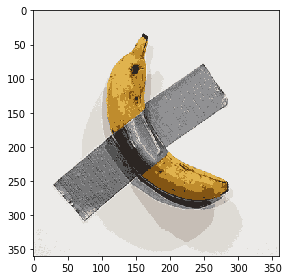

In [65]:
image = io.imread("banana.jpg")
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(rows*cols, 3)
clusters = [3, 5, 10]
for c in clusters:
    compressed_image = kMeans_compressor("banana.jpg", c)
    io.imshow(compressed_image)
    io.show()

In [68]:
mc = pd.read_csv("Mall_Customers.csv")
mc.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [69]:
mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [70]:
mc.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [71]:
mc.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [73]:
# checking for duplicate rows
mc.duplicated().sum()

0

In [75]:
# checking for NaN values
mc.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [76]:
mc.drop('CustomerID',axis=1,inplace=True)
mc.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


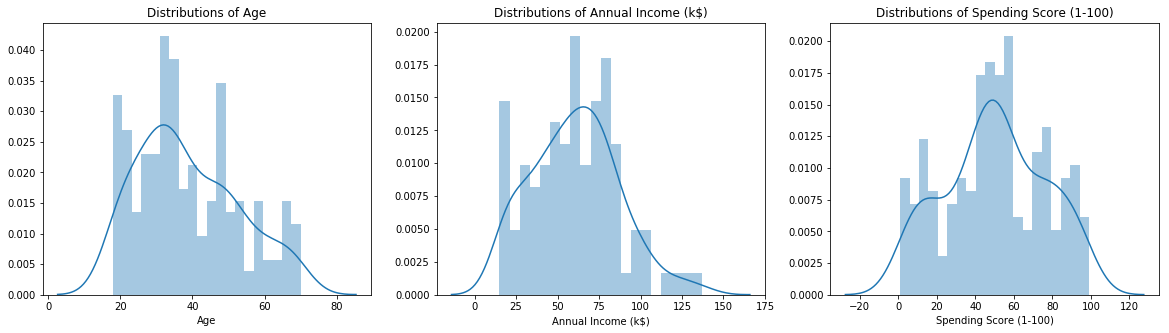

In [81]:
plt.figure(1,figsize=(20,5))
n=0
for x in ['Age','Annual Income (k$)','Spending Score (1-100)']:
    n+=1
    plt.subplot(1,3,n)
    sns.distplot(mc[x],bins=20)
    plt.title('Distributions of '+x)
plt.show()

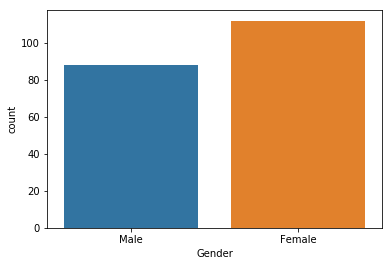

In [82]:
sns.countplot(mc['Gender'])

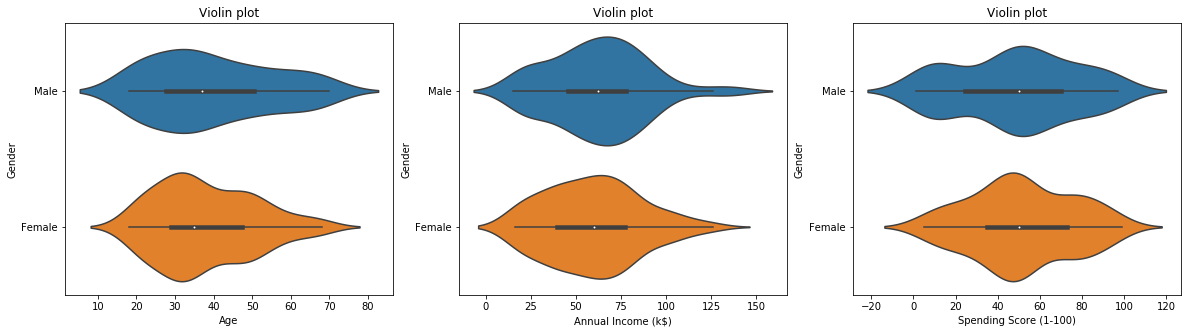

In [83]:
plt.figure(1, figsize = (20, 5))
n = 0
for cols in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    sns.violinplot(x = cols, y = 'Gender', data = mc)
    plt.title('Violin plot')    
plt.show()

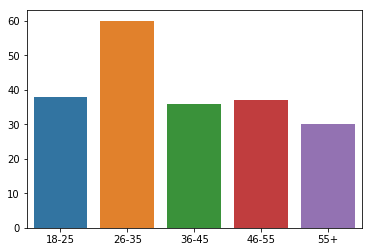

In [87]:
age_18_25=mc[(mc['Age']>=18) & (mc['Age']<=25 )]
age_26_35=mc[(mc['Age']>=26) & (mc['Age']<=35) ]
age_36_45=mc[(mc['Age']>=36) & (mc['Age']<=45) ]
age_46_55=mc[(mc['Age']>=46) & (mc['Age']<=55) ]
age_55above=mc[mc['Age']>=55 ]
agex=['18-25','26-35','36-45','46-55','55+']
agey=[len(age_18_25.values),len(age_26_35.values),len(age_36_45.values),len(age_46_55.values),len(age_55above.values)]
sns.barplot(x=agex,y=agey)

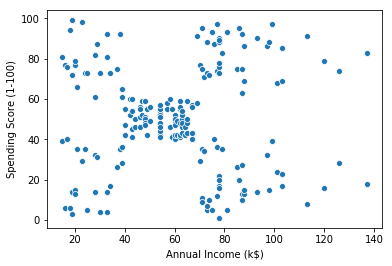

In [89]:
sns.scatterplot(x=mc['Annual Income (k$)'],y=mc['Spending Score (1-100)'])

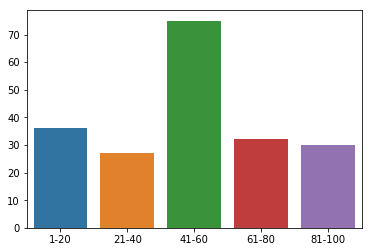

In [91]:
ss_1_20=mc['Spending Score (1-100)'][(mc['Spending Score (1-100)']>=1) & (mc['Spending Score (1-100)']<=20)]
ss_21_40=mc['Spending Score (1-100)'][(mc['Spending Score (1-100)']>=21) & (mc['Spending Score (1-100)']<=40)]
ss_41_60=mc['Spending Score (1-100)'][(mc['Spending Score (1-100)']>=41) & (mc['Spending Score (1-100)']<=60)]
ss_61_80=mc['Spending Score (1-100)'][(mc['Spending Score (1-100)']>=61) & (mc['Spending Score (1-100)']<=80)]
ss_81_100=mc['Spending Score (1-100)'][(mc['Spending Score (1-100)']>=81) & (mc['Spending Score (1-100)']<=100)]
ssx=['1-20','21-40','41-60','61-80','81-100']
ssy=[len(ss_1_20.values),len(ss_21_40.values),len(ss_41_60.values),len(ss_61_80.values),len(ss_81_100.values)]
sns.barplot(x=ssx,y=ssy)

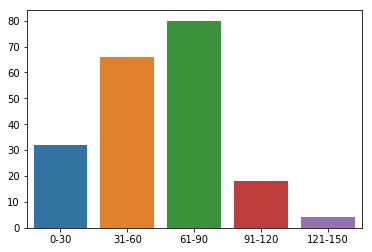

In [93]:
ai_0_30=mc['Annual Income (k$)'][(mc['Annual Income (k$)']>=0) & (mc['Annual Income (k$)']<=30)]
ai_31_60=mc['Annual Income (k$)'][(mc['Annual Income (k$)']>=31) & (mc['Annual Income (k$)']<=60)]
ai_61_90=mc['Annual Income (k$)'][(mc['Annual Income (k$)']>=61) & (mc['Annual Income (k$)']<=90)]
ai_91_120=mc['Annual Income (k$)'][(mc['Annual Income (k$)']>=91) & (mc['Annual Income (k$)']<=120)]
ai_121_150=mc['Annual Income (k$)'][(mc['Annual Income (k$)']>=121) & (mc['Annual Income (k$)']<=150)]
aix=['0-30','31-60','61-90','91-120','121-150']
aiy=[len(ai_0_30.values),len(ai_31_60.values),len(ai_61_90.values),len(ai_91_120.values),len(ai_121_150.values)]
sns.barplot(x=aix,y=aiy)

In [50]:
X1 = mc.loc[:,['Age', 'Spending Score (1-100)']].values
kmeans = kMeans(k=4)
em = EM(k=4)
label = kmeans.predict(X1)
label2 = em.predict(X1)
print(kmeans.calculate_means())
print(em.calculate_means())

[[55.70833333 48.22916667]
 [30.1754386  82.35087719]
 [43.29166667 15.02083333]
 [27.61702128 49.14893617]]
[[30.11042393 80.74758324]
 [51.35523588 45.76599316]
 [43.3060645  13.4700225 ]
 [24.6590367  50.04242591]]


In [156]:
print(score_SSE(kmeans.calculate_means(), label, X1))
print(score_SSE(em.calculate_means(), label2, X1))

396240.44673867174
463497.1563360727


In [162]:
print(score_Silhouette(X1, label))
print(score_Silhouette(X1, label2))

0.49973941540141753
0.47978714570282177


In [158]:
print(score_Calinski_Harabasz(X1, label))
print(score_Calinski_Harabasz(X1, label2))

332.5631268443306
306.5523003356236


In [159]:
print(score_Davies_Bouldin(X1, label))
print(score_Davies_Bouldin(X1, label2))

0.6869328339833629
0.6882787275252393


In [184]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
km_score = []
em_score = []
km_si_score = []
em_si_score = []
km_ch_score = []
em_ch_score = []
km_db_score = []
em_db_score = []
for i in range(2,10):
    km = kMeans(k=4)
    em = EM(k=4)
    kmp = km.predict(X1)
    emp = em.predict(X1)
    print("k-Means SSE Score for number of cluster(s) {}: {}".format(i,score_SSE(km.calculate_means(), kmp, X1)))
    km_score.append(score_SSE(km.calculate_means(), kmp, X1))
    print("EM SSE Score for number of cluster(s) {}: {}".format(i,score_SSE(em.calculate_means(), kmp, X1)))
    em_score.append(score_SSE(em.calculate_means(), emp, X1))
    print("k-Means Silhouette score for number of cluster(s) {}: {}".format(i,score_Silhouette(X1, kmp)))
    km_si_score.append(score_Silhouette(X1, kmp))
    print("EM Silhouette score for number of cluster(s) {}: {}".format(i,score_Silhouette(X1, emp)))
    em_si_score.append(score_Silhouette(X1, emp))
    print("k-Means Davies-Bouldin score for number of cluster(s) {}: {}".format(i,score_Davies_Bouldin(X1, kmp)))
    km_db_score.append(score_Davies_Bouldin(X1, kmp))
    print("EM Davies-Bouldin score for number of cluster(s) {}: {}".format(i,score_Davies_Bouldin(X1, emp)))
    em_db_score.append(score_Davies_Bouldin(X1, emp))
    print("k-Means Calinski-Harabasz score for number of cluster(s) {}: {}".format(i,score_Calinski_Harabasz(X1, kmp)))
    km_ch_score.append(score_Calinski_Harabasz(X1, kmp))
    print("EM Calinski-Harabasz score for number of cluster(s) {}: {}".format(i,score_Calinski_Harabasz(X1, emp)))
    em_ch_score.append(score_Calinski_Harabasz(X1, emp))
    print("-"*70)

k-Means SSE Score for number of cluster(s) 2: 264393.99281794333
EM SSE Score for number of cluster(s) 2: 261950.02222730088
k-Means Silhouette score for number of cluster(s) 2: 0.4692341232501655
EM Silhouette score for number of cluster(s) 2: 0.4600811747963419
k-Means Davies-Bouldin score for number of cluster(s) 2: 0.7722203222724408
EM Davies-Bouldin score for number of cluster(s) 2: 0.8077766432721085
k-Means Calinski-Harabasz score for number of cluster(s) 2: 249.19429134176448
EM Calinski-Harabasz score for number of cluster(s) 2: 234.82743627008995
----------------------------------------------------------------------
k-Means SSE Score for number of cluster(s) 3: 452641.1882551276
EM SSE Score for number of cluster(s) 3: 430155.68480886146
k-Means Silhouette score for number of cluster(s) 3: 0.45300127016521263
EM Silhouette score for number of cluster(s) 3: 0.44285943011240614
k-Means Davies-Bouldin score for number of cluster(s) 3: 0.8289661440930112
EM Davies-Bouldin score 

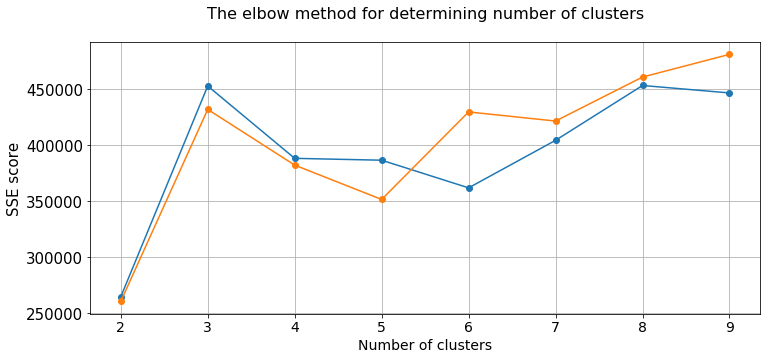

In [185]:
plt.figure(figsize=(12,5))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.plot([i for i in range(2,10)],km_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_score, marker = 'o')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("SSE score",fontsize=15)
plt.xticks([i for i in range(2,10)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

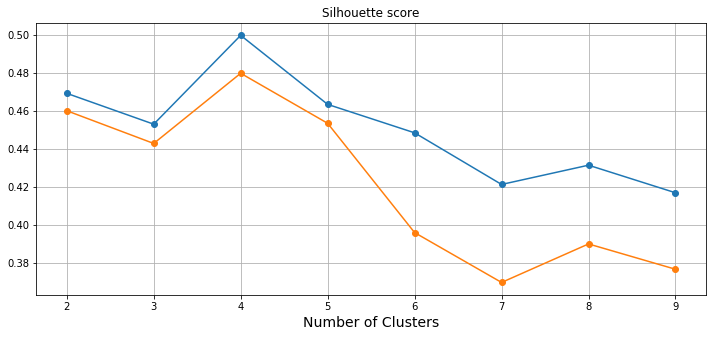

In [186]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,10)],km_si_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_si_score, marker = 'o')
plt.grid(True)
plt.xlabel('Number of Clusters',fontsize=14)
plt.title("Silhouette score")
plt.show()

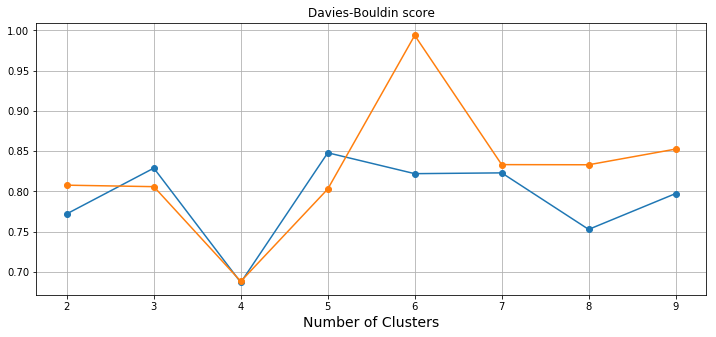

In [187]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,10)],km_db_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_db_score, marker = 'o')
plt.grid(True)
plt.xlabel('Number of Clusters',fontsize=14)
plt.title("Davies-Bouldin score")
plt.show()

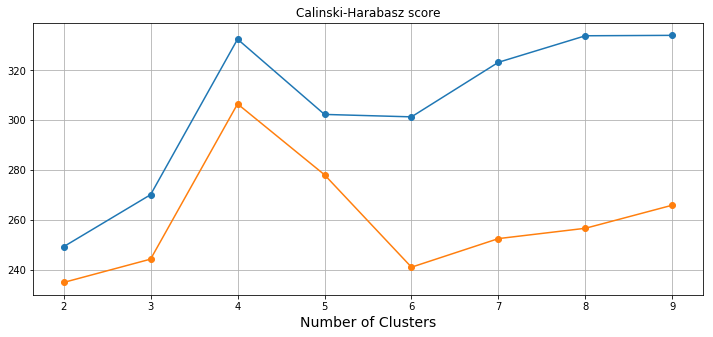

In [188]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,10)],km_ch_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_ch_score, marker = 'o')
plt.grid(True)
plt.xlabel('Number of Clusters',fontsize=14)
plt.title("Calinski-Harabasz score")
plt.show()

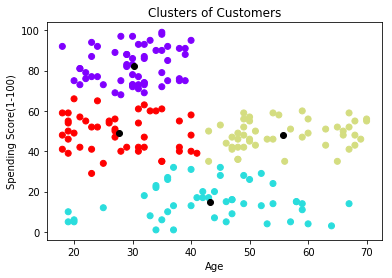

In [44]:
plt.scatter(X1[:,0],X1[:,1],c=kmp,cmap='rainbow')
plt.scatter(km.calculate_means()[:,0],kmeans.calculate_means()[:,1],color='black')
plt.title('Clusters of Customers')
plt.xlabel('Age')
plt.ylabel('Spending Score(1-100)')
plt.show()

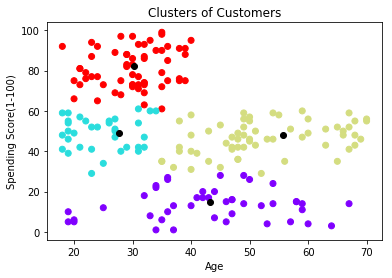

In [46]:
plt.scatter(X1[:,0],X1[:,1],c=emp,cmap='rainbow')
plt.scatter(kmeans.calculate_means()[:,0],kmeans.calculate_means()[:,1],color='black')
plt.title('Clusters of Customers')
plt.xlabel('Age')
plt.ylabel('Spending Score(1-100)')
plt.show()

In [165]:
X2 = mc.iloc[:,1:].values
km = kMeans(k = 5)
em = EM(k = 5)
kmp = km.fit_predict(X2)
emp = em.fit_predict(X2)
print(km.calculate_means())
print(em.calculate_means())

[[43.08860759 55.29113924 49.56962025  2.10126582]
 [25.52173913 26.30434783 78.56521739  3.        ]
 [32.69230769 86.53846154 82.12820513  0.        ]
 [40.66666667 87.75       17.58333333  1.11111111]
 [45.2173913  26.30434783 20.91304348  4.        ]]
[[ 33.74937334 124.00169012  81.74898597   0.        ]
 [ 43.16656176  49.4261023   43.08355589   2.51850615]
 [ 32.57152493  82.25787879  82.17163149   0.        ]
 [ 41.00000005  89.40623325  15.59370445   1.        ]
 [ 24.80953205  25.6188737   80.23829746   3.        ]]


In [166]:
print(score_SSE(km.calculate_means(), kmp, X2))
print(score_SSE(em.calculate_means(), emp, X2))

831735.9003993591
1275771.566501506


In [167]:
print(score_Silhouette(X2, kmp))
print(score_Silhouette(X2, emp))

0.4445747864559597
0.3890527432399445


In [168]:
print(score_Calinski_Harabasz(X2, kmp))
print(score_Calinski_Harabasz(X2, emp))

151.19296799666802
101.37390810728554


In [169]:
print(score_Davies_Bouldin(X2, kmp))
print(score_Davies_Bouldin(X2, emp))

0.8213958726036467
0.7686643999618015


In [190]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
km_score = []
em_score = []
km_si_score = []
em_si_score = []
km_ch_score = []
em_ch_score = []
km_db_score = []
em_db_score = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=0)
    em = GM(n_components=i)
    kmp = km.fit_predict(X2)
    emp = em.fit_predict(X2)    
    print("k-Means SSE Score for number of cluster(s) {}: {}".format(i,score_SSE(km.cluster_centers_, kmp, X2)))
    km_score.append(score_SSE(km.cluster_centers_, kmp, X2))
    print("EM SSE Score for number of cluster(s) {}: {}".format(i,score_SSE(em.means_, kmp, X2)))
    em_score.append(score_SSE(em.means_, emp, X2))
    print("k-Means Silhouette score for number of cluster(s) {}: {}".format(i,score_Silhouette(X2, kmp)))
    km_si_score.append(score_Silhouette(X2, kmp))
    print("EM Silhouette score for number of cluster(s) {}: {}".format(i,score_Silhouette(X2, emp)))
    em_si_score.append(score_Silhouette(X2, emp))
    print("k-Means Davies-Bouldin score for number of cluster(s) {}: {}".format(i,score_Davies_Bouldin(X2, kmp)))
    km_db_score.append(score_Davies_Bouldin(X2, kmp))
    print("EM Davies-Bouldin score for number of cluster(s) {}: {}".format(i,score_Davies_Bouldin(X2, emp)))
    em_db_score.append(score_Davies_Bouldin(X2, emp))
    print("k-Means Calinski-Harabasz score for number of cluster(s) {}: {}".format(i,score_Calinski_Harabasz(X2, kmp)))
    km_ch_score.append(score_Calinski_Harabasz(X2, kmp))
    print("EM Calinski-Harabasz score for number of cluster(s) {}: {}".format(i,score_Calinski_Harabasz(X2, emp)))
    em_ch_score.append(score_Calinski_Harabasz(X2, emp))
    print("-"*70)

k-Means SSE Score for number of cluster(s) 2: 669627.5746495655
EM SSE Score for number of cluster(s) 2: 789716.1446943971
k-Means Silhouette score for number of cluster(s) 2: 0.29301886020890355
EM Silhouette score for number of cluster(s) 2: 0.30179883974632377
k-Means Davies-Bouldin score for number of cluster(s) 2: 1.3579624562235841
EM Davies-Bouldin score for number of cluster(s) 2: 1.5318389726638615
k-Means Calinski-Harabasz score for number of cluster(s) 2: 89.19508278310555
EM Calinski-Harabasz score for number of cluster(s) 2: 72.83377218515514
----------------------------------------------------------------------
k-Means SSE Score for number of cluster(s) 3: 1213454.1263402682
EM SSE Score for number of cluster(s) 3: 1245383.6739444013
k-Means Silhouette score for number of cluster(s) 3: 0.38420168825476614
EM Silhouette score for number of cluster(s) 3: 0.37972398174965943
k-Means Davies-Bouldin score for number of cluster(s) 3: 0.8745640576647172
EM Davies-Bouldin score f

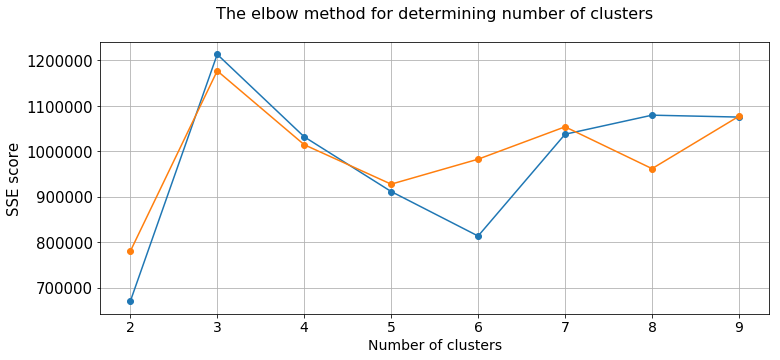

In [191]:
plt.figure(figsize=(12,5))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.plot([i for i in range(2,10)],km_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_score, marker = 'o')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("SSE score",fontsize=15)
plt.xticks([i for i in range(2,10)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

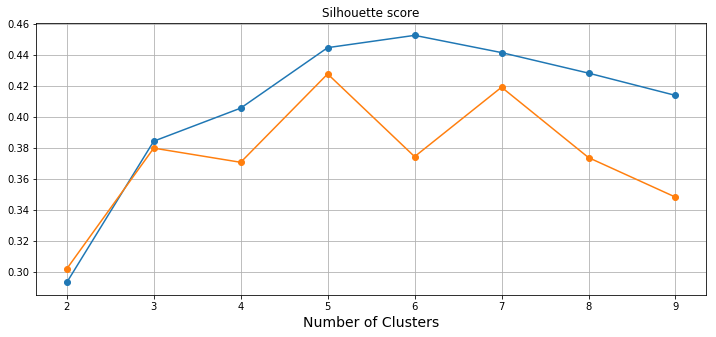

In [192]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,10)],km_si_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_si_score, marker = 'o')
plt.grid(True)
plt.xlabel('Number of Clusters',fontsize=14)
plt.title("Silhouette score")
plt.show()

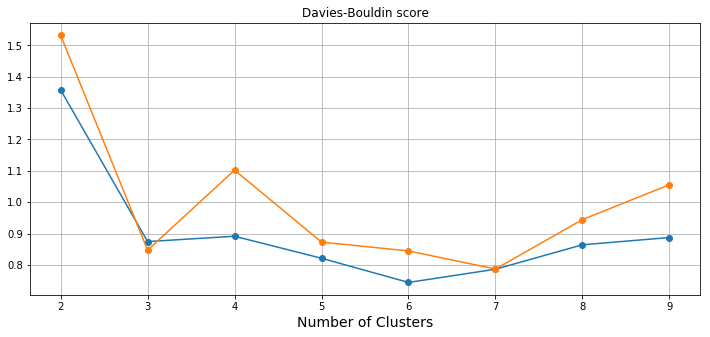

In [193]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,10)],km_db_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_db_score, marker = 'o')
plt.grid(True)
plt.xlabel('Number of Clusters',fontsize=14)
plt.title("Davies-Bouldin score")
plt.show()

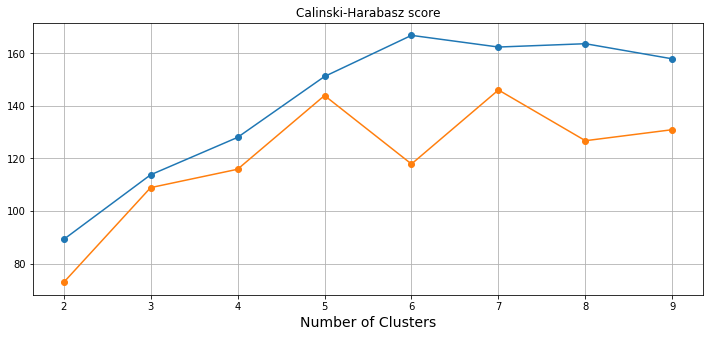

In [194]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,10)],km_ch_score, marker = 'o')
plt.plot([i for i in range(2,10)],em_ch_score, marker = 'o')
plt.grid(True)
plt.xlabel('Number of Clusters',fontsize=14)
plt.title("Calinski-Harabasz score")
plt.show()

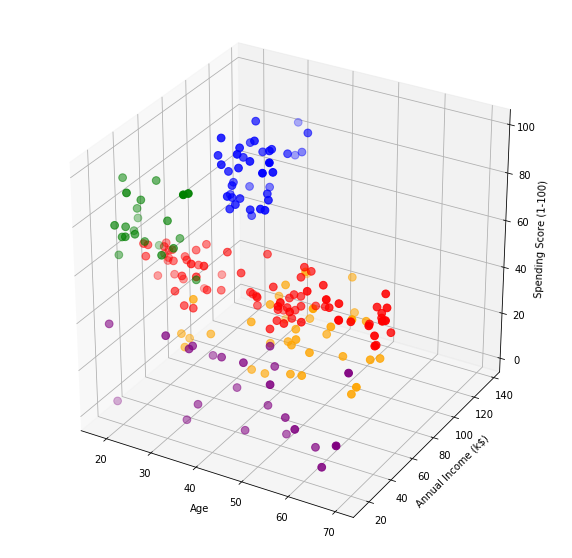

In [127]:
clusters = km.fit_predict(X2)
mc['label'] = clusters
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(mc.Age[mc.label==0],mc['Annual Income (k$)'][mc.label==0],mc['Spending Score (1-100)'][mc.label==0],c='red',s=60)
ax.scatter(mc.Age[mc.label==1],mc['Annual Income (k$)'][mc.label==1],mc['Spending Score (1-100)'][mc.label==1],c='blue',s=60)
ax.scatter(mc.Age[mc.label==2],mc['Annual Income (k$)'][mc.label==2],mc['Spending Score (1-100)'][mc.label==2],c='green',s=60)
ax.scatter(mc.Age[mc.label==3],mc['Annual Income (k$)'][mc.label==3],mc['Spending Score (1-100)'][mc.label==3],c='orange',s=60)
ax.scatter(mc.Age[mc.label==4],mc['Annual Income (k$)'][mc.label==4],mc['Spending Score (1-100)'][mc.label==4],c='purple',s=60)
#ax.view_init(30,185)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()

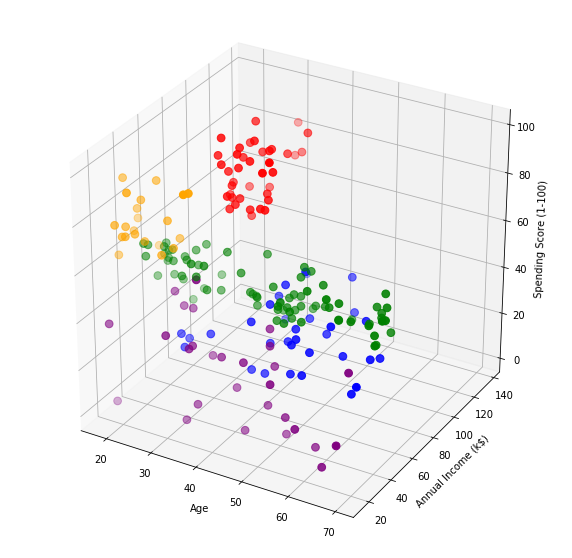

In [39]:
clusters = em.fit_predict(X2)
mc['label'] = clusters
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mc.Age[mc.label==0],mc['Annual Income (k$)'][mc.label==0],mc['Spending Score (1-100)'][mc.label==0],c='red',s=60)
ax.scatter(mc.Age[mc.label==1],mc['Annual Income (k$)'][mc.label==1],mc['Spending Score (1-100)'][mc.label==1],c='blue',s=60)
ax.scatter(mc.Age[mc.label==2],mc['Annual Income (k$)'][mc.label==2],mc['Spending Score (1-100)'][mc.label==2],c='green',s=60)
ax.scatter(mc.Age[mc.label==3],mc['Annual Income (k$)'][mc.label==3],mc['Spending Score (1-100)'][mc.label==3],c='orange',s=60)
ax.scatter(mc.Age[mc.label==4],mc['Annual Income (k$)'][mc.label==4],mc['Spending Score (1-100)'][mc.label==4],c='purple',s=60)
#ax.view_init(30,185)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()